# ZNEUS - Project 1


In [166]:
!pip install shapely


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import pylab as py
from scipy import stats
from scipy.stats import pearsonr
import sklearn
import sklearn.preprocessing as preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from shapely import Polygon, Point
from typing import List
import os
import joblib
TRANSFORMED_PATH = "data/transformed"
r_seed = 42

## 1. EDA
### 1.1 Loading Dataset

In [168]:
df = pd.read_csv('data/houses.csv')
df.head()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


### 1.2 Info about dataset

In [169]:
print(df.info(),"\n")

print("Unique values:")
for col in df.columns:
    print("\t",col + " počet unikátnych záznamov: ", len(df[col].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None 

Unique values:
	 median_house_value počet unikátnych záznamov:  3842
	 median_income počet unikátnych záznamov:  12928
	 housing_median_age počet unikátnych záznamov:  52
	 total_rooms počet unikátnych záznamov:  5926
	 total_bedrooms počet unikátnych záznamov:  1928
	 population počet unikátnych záznamov

This dataset contains 9 columns and 20640 entries, all columns are of type float64, therefore are numerical.

Some columns have a lot of unique values.

Target column is **median_house_value**.

### 1.3 Duplicates

In [170]:
duplicates = df.duplicated()
print(df[duplicates])

Empty DataFrame
Columns: [median_house_value, median_income, housing_median_age, total_rooms, total_bedrooms, population, households, latitude, longitude]
Index: []


This implicates, that there are no duplicates.

### 1.4 Missing data

In [171]:
print(df.isna().sum())

median_house_value    0
median_income         0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
latitude              0
longitude             0
dtype: int64


There are also no missing data, what a nice dataset.

### 1.5 Outliers

In [172]:
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return column[(column < lower) | (column > upper)].shape[0]

#apply to all columns
outliers_count = df.apply(count_outliers)

print(outliers_count)

median_house_value    1071
median_income          681
housing_median_age       0
total_rooms           1287
total_bedrooms        1282
population            1196
households            1220
latitude                 0
longitude                0
dtype: int64


We can see, that we have numerous outliers in some columns.

(32.0, 42.5)

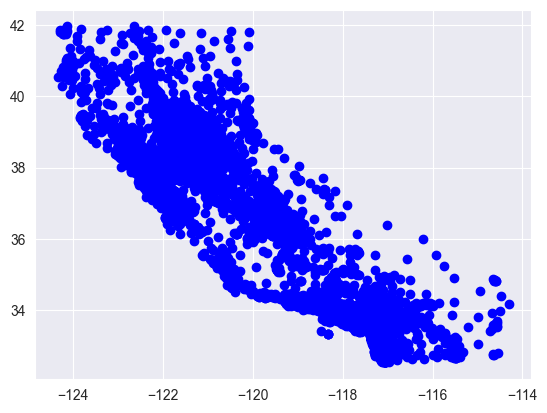

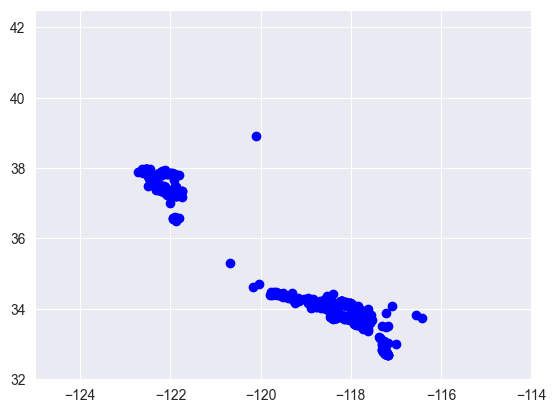

In [173]:
def get_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] < lower) | (df[column] > upper)]

outs = get_outliers("median_house_value")
house_outs = get_outliers("median_income")
plt.figure()
plt.scatter(df["longitude"], df["latitude"], color='blue', marker='o')
plt.figure()
plt.scatter(outs["longitude"], outs["latitude"], color='blue', marker='o')
plt.xlim(-125, -114)
plt.ylim(32, 42.5)

(32.0, 42.5)

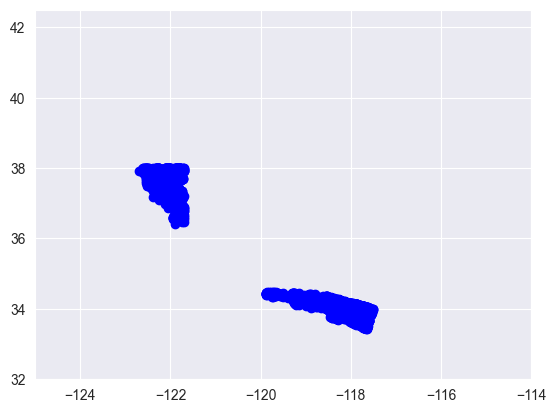

In [174]:
def set_is_san_francisco(df: pd.DataFrame):
    df["is_san_francisco"] = ((df["longitude"] <= -121.7) & (df["longitude"] > -122.7) \
        & (df["latitude"] > 36.3) & (df["latitude"] <= 38)).astype(int)

la_polygon = Polygon([
    (-119.9, 34.5),
    (-118.6, 34.4),
    (-117.5, 34),
    (-117.65, 33.4),
    (-119.9, 34.4),
])
def set_is_los_angeles(df: pd.DataFrame):
    df["is_los_angeles"] = df.apply(
        lambda row: int(la_polygon.contains(Point(row["longitude"], row["latitude"]))),
        axis=1
    )

set_is_san_francisco(df)
set_is_los_angeles(df)
plt.figure()
_df = df[(df["is_san_francisco"] == 1) | (df["is_los_angeles"] == 1)]
plt.scatter(_df["longitude"], _df["latitude"], color='blue', marker='o')
plt.xlim(-125, -114)
plt.ylim(32, 42.5)

As we can see most of the outliers are focused in specific areas indicating that they are probably result of being located in big cities such as LA

#### 1.5.1 Outlier imputation

In [175]:
def clip_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return column.clip(lower, upper) #if value is lower then min, replace it with min, same with max

#apply to all
df.apply(clip_outliers)

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude,is_san_francisco,is_los_angeles
0,452600.0,8.013025,41.0,880.000,129.0,322.0,126.0,37.88,-122.23,0,0
1,358500.0,8.013025,21.0,5698.375,1106.0,2401.0,1092.5,37.86,-122.22,0,0
2,352100.0,7.257400,52.0,1467.000,190.0,496.0,177.0,37.85,-122.24,0,0
3,341300.0,5.643100,52.0,1274.000,235.0,558.0,219.0,37.85,-122.25,0,0
4,342200.0,3.846200,52.0,1627.000,280.0,565.0,259.0,37.85,-122.25,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20635,78100.0,1.560300,25.0,1665.000,374.0,845.0,330.0,39.48,-121.09,0,0
20636,77100.0,2.556800,18.0,697.000,150.0,356.0,114.0,39.49,-121.21,0,0
20637,92300.0,1.700000,17.0,2254.000,485.0,1007.0,433.0,39.43,-121.22,0,0
20638,84700.0,1.867200,18.0,1860.000,409.0,741.0,349.0,39.43,-121.32,0,0


### 1.6 Valid data ranges

In [176]:
#latitude
invalid_lat = df[(df['latitude'] < -90) | (df['latitude'] > 90)]
print("Počet invalid latitude:", invalid_lat.shape[0])

#longitude
invalid_long = df[(df['longitude'] < -180) | (df['longitude'] > 180)]
print("Počet invalid longitude:", invalid_long.shape[0])

#negative values in other columns
df.min()

Počet invalid latitude: 0
Počet invalid longitude: 0


median_house_value    14999.0000
median_income             0.4999
housing_median_age        1.0000
total_rooms               2.0000
total_bedrooms            1.0000
population                3.0000
households                1.0000
latitude                 32.5400
longitude              -124.3500
is_san_francisco          0.0000
is_los_angeles            0.0000
dtype: float64

There are no negative values or zero values in other columns, this is okay. Lat and Long are both in valid ranges.

### 1.7 Summary statistics

In [177]:
df.describe()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude,is_san_francisco,is_los_angeles
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,206855.816909,3.870671,28.639486,2635.763081,537.898014,1425.476744,499.539680,35.631861,-119.569704,0.190504,0.381444
std,115395.615874,1.899822,12.585558,2181.615252,421.247906,1132.462122,382.329753,2.135952,2.003532,0.392708,0.485753
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000,0.000000,0.000000
25%,119600.000000,2.563400,18.000000,1447.750000,295.000000,787.000000,280.000000,33.930000,-121.800000,0.000000,0.000000
50%,179700.000000,3.534800,29.000000,2127.000000,435.000000,1166.000000,409.000000,34.260000,-118.490000,0.000000,0.000000
75%,264725.000000,4.743250,37.000000,3148.000000,647.000000,1725.000000,605.000000,37.710000,-118.010000,0.000000,1.000000
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000,1.000000,1.000000


In [178]:
print("Other stats:")
for col in df.columns:
    print("\t",col,":")
    print("\t\t","mean", np.mean(df[col]))
    print("\t\t","median", np.median(df[col]))
    print("\t\t","mode", stats.mode(df[col])[0])
    print("\t\t","variance", np.var(df[col]),"\n")

Other stats:
	 median_house_value :
		 mean 206855.81690891474
		 median 179700.0
		 mode 500001.0
		 variance 13315503000.818077 

	 median_income :
		 mean 3.8706710029069766
		 median 3.5347999999999997
		 mode 3.125
		 variance 3.609147689697444 

	 housing_median_age :
		 mean 28.639486434108527
		 median 29.0
		 mode 52.0
		 variance 158.38858617035862 

	 total_rooms :
		 mean 2635.7630813953488
		 median 2127.0
		 mode 1527.0
		 variance 4759214.512668024 

	 total_bedrooms :
		 mean 537.8980135658915
		 median 435.0
		 mode 280.0
		 variance 177441.20088752697 

	 population :
		 mean 1425.4767441860465
		 median 1166.0
		 mode 891.0
		 variance 1282408.3220366866 

	 households :
		 mean 499.5396802325581
		 median 409.0
		 mode 306.0
		 variance 146168.95772780472 

	 latitude :
		 mean 35.63186143410853
		 median 34.26
		 mode 34.06
		 variance 4.562071602892517 

	 longitude :
		 mean -119.56970445736432
		 median -118.49
		 mode -118.31
		 variance 4.0139448835847835 

	 

### 1.8 Visualize data

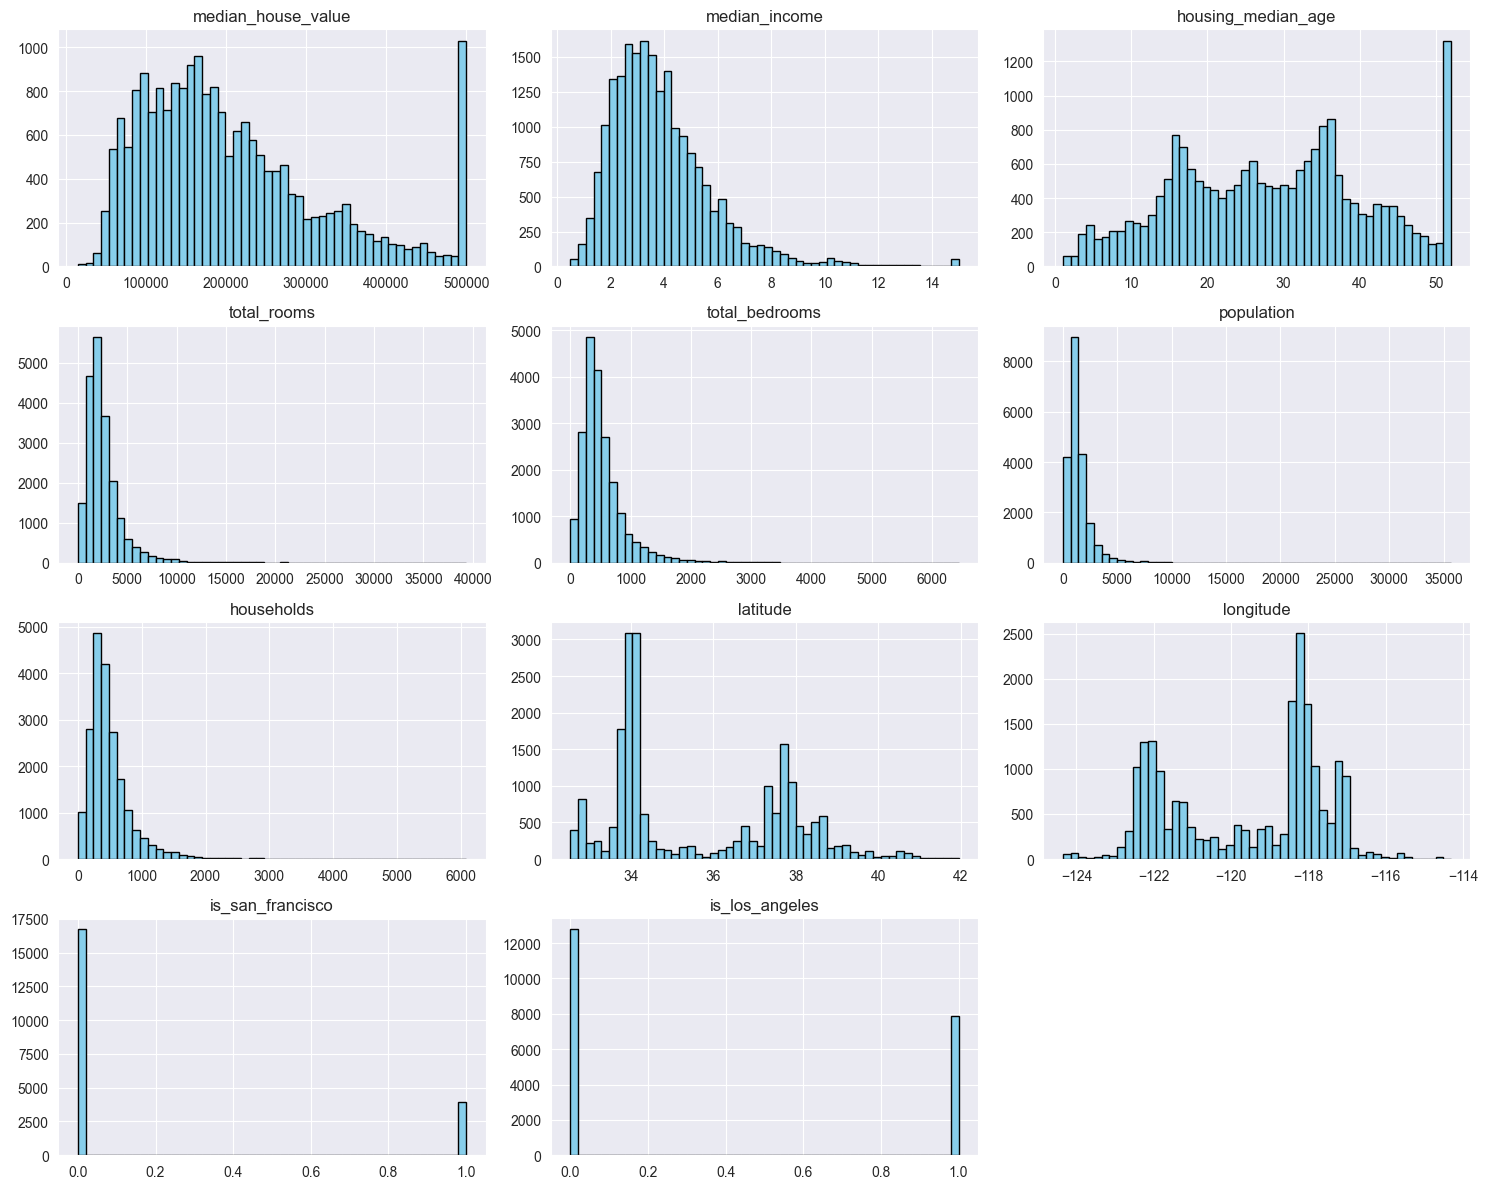

In [179]:
df.hist(bins=50, figsize=(15, 12), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

None of these distributions appear normal, lets run some tests.

#### 1.8.1 Test for normality

median_house_value :


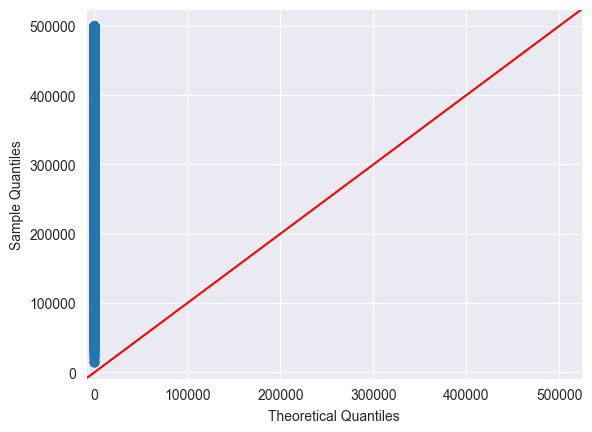

Kolmogorov-Smirnov test: KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(14999.0), statistic_sign=np.int8(-1))
Another distribution (reject H0)

median_income :


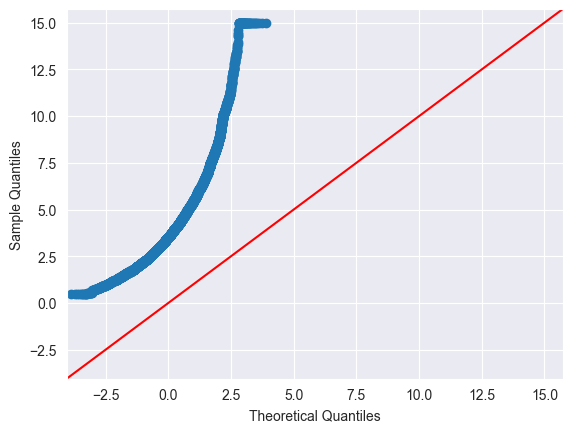

Kolmogorov-Smirnov test: KstestResult(statistic=np.float64(0.8953266796146241), pvalue=np.float64(0.0), statistic_location=np.float64(1.5809), statistic_sign=np.int8(-1))
Another distribution (reject H0)

housing_median_age :


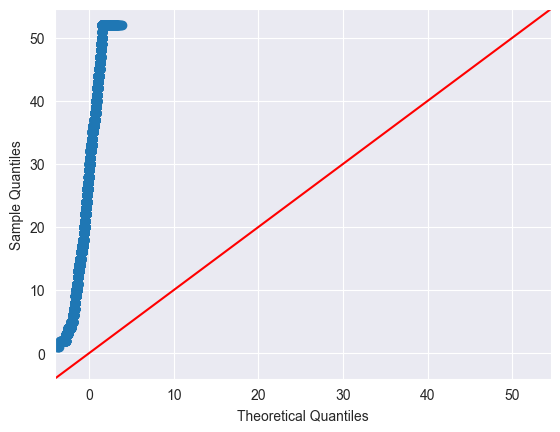

Kolmogorov-Smirnov test: KstestResult(statistic=np.float64(0.9956462259993777), pvalue=np.float64(0.0), statistic_location=np.float64(3.0), statistic_sign=np.int8(-1))
Another distribution (reject H0)

total_rooms :


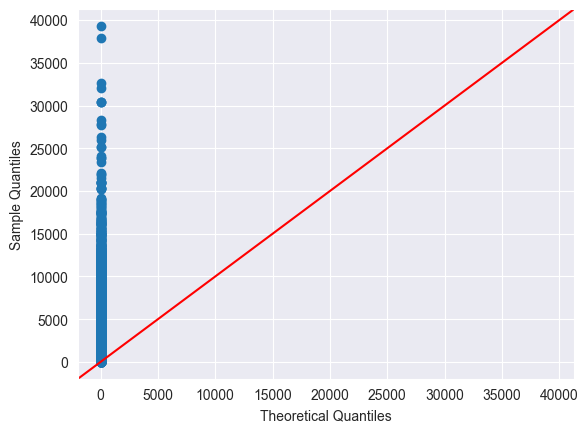

Kolmogorov-Smirnov test: KstestResult(statistic=np.float64(0.9999515494010092), pvalue=np.float64(0.0), statistic_location=np.float64(6.0), statistic_sign=np.int8(-1))
Another distribution (reject H0)

total_bedrooms :


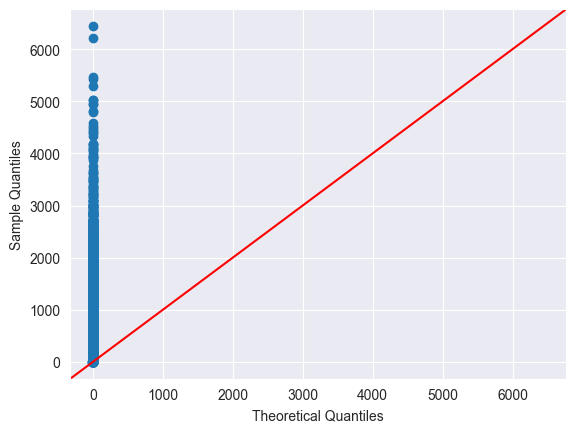

Kolmogorov-Smirnov test: KstestResult(statistic=np.float64(0.999580731858942), pvalue=np.float64(0.0), statistic_location=np.float64(4.0), statistic_sign=np.int8(-1))
Another distribution (reject H0)

population :


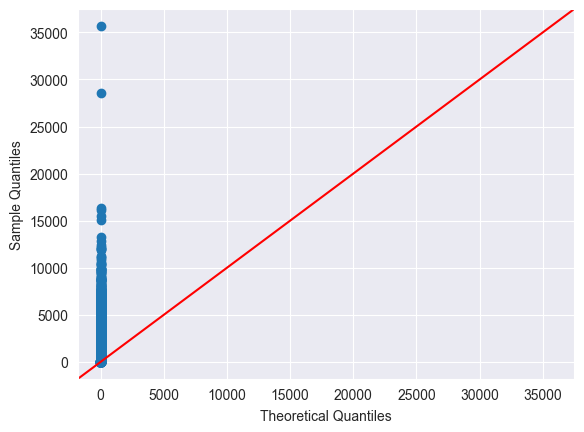

Kolmogorov-Smirnov test: KstestResult(statistic=np.float64(0.9999512637360249), pvalue=np.float64(0.0), statistic_location=np.float64(5.0), statistic_sign=np.int8(-1))
Another distribution (reject H0)

households :


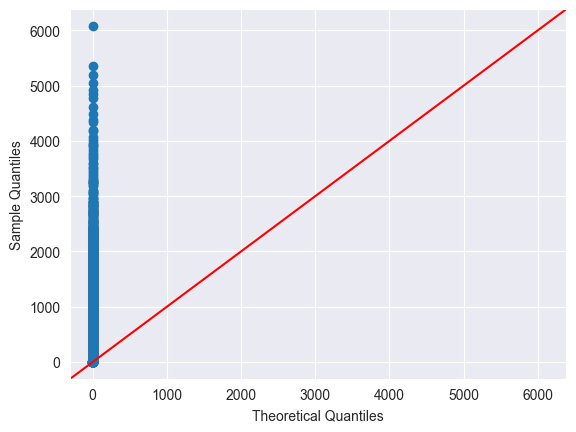

Kolmogorov-Smirnov test: KstestResult(statistic=np.float64(0.999580731858942), pvalue=np.float64(0.0), statistic_location=np.float64(4.0), statistic_sign=np.int8(-1))
Another distribution (reject H0)

latitude :


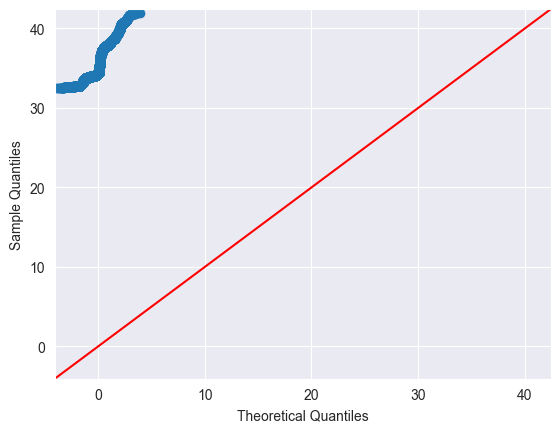

Kolmogorov-Smirnov test: KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(32.54), statistic_sign=np.int8(-1))
Another distribution (reject H0)

longitude :


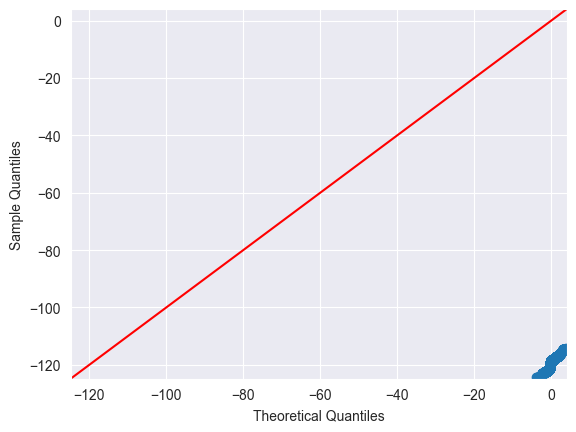

Kolmogorov-Smirnov test: KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(-114.31), statistic_sign=np.int8(1))
Another distribution (reject H0)

is_san_francisco :


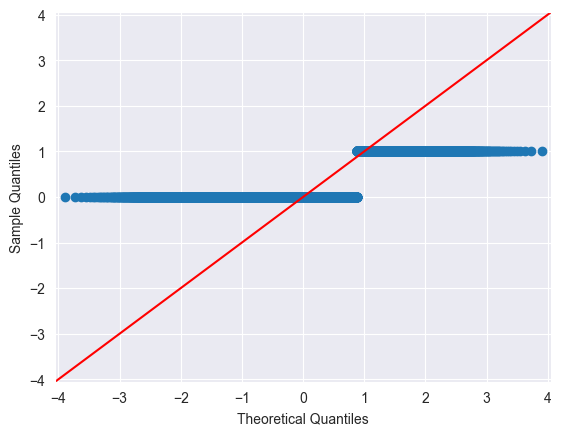

Kolmogorov-Smirnov test: KstestResult(statistic=np.float64(0.5), pvalue=np.float64(0.0), statistic_location=np.int64(0), statistic_sign=np.int8(-1))
Another distribution (reject H0)

is_los_angeles :


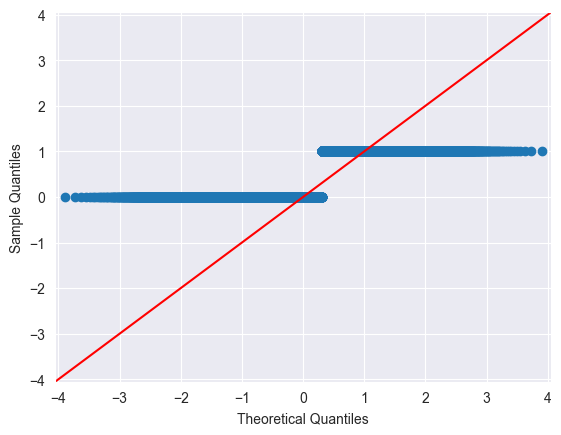

Kolmogorov-Smirnov test: KstestResult(statistic=np.float64(0.5), pvalue=np.float64(0.0), statistic_location=np.int64(0), statistic_sign=np.int8(-1))
Another distribution (reject H0)



In [180]:
def check_normal(col):
    print(col.name,":")
    #draw qqplot
    sm.qqplot(col, line='45')
    py.show()
    
    #perform KS test, we dont do shapiro because we hove more than 5000 samples
    kolmogorov_smirnov = stats.kstest(col, "norm")
    
    #interpret results
    alpha = 0.05
    
    print("Kolmogorov-Smirnov test:", kolmogorov_smirnov)
    if kolmogorov_smirnov.pvalue > alpha:
        print('Normal distribution (fail to reject H0)\n')
    else:
        print('Another distribution (reject H0)\n')
    
for col in df:
    check_normal(df[col])

### 1.9 Correlations

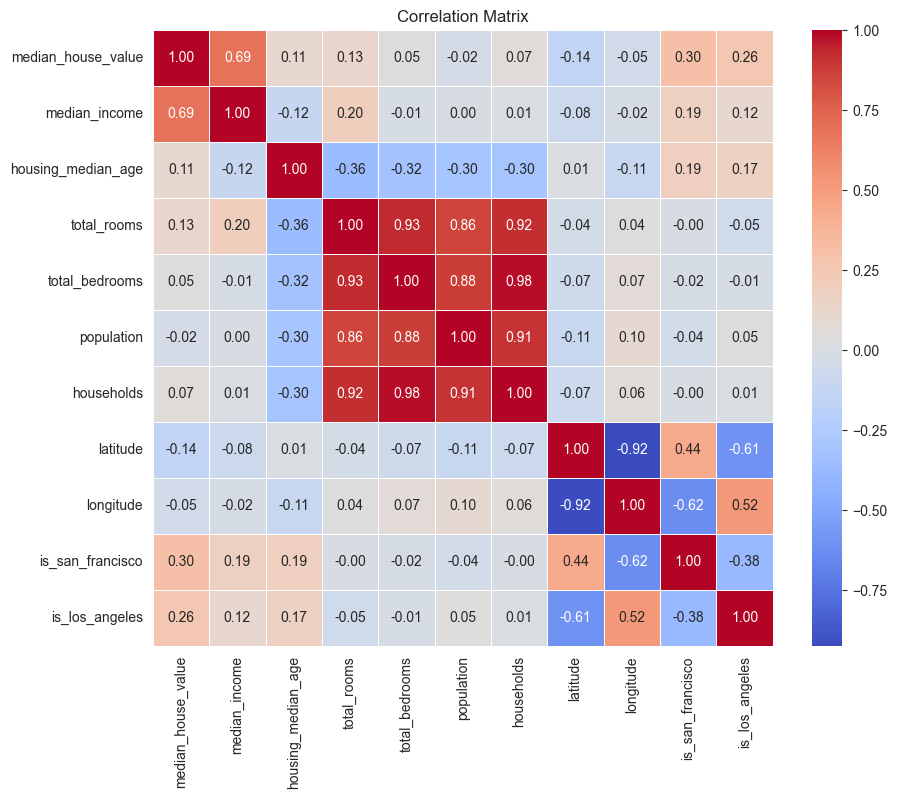

In [181]:
correlation_matrix = df.corr()

#visualize the correlation matrix in a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

We can see, that columns: median_income (0.69) is strongly positively correlated with the target column.

Other columns are correlated between each other such as: total_rooms - households,population, total_bedrooms, hoouse_median_age and more.

### 1.10 Hypothesis testing
##### H0 - median_house_value is not dependent on median_income
##### H1 - median_house_value increases as median_income increases

#### 1.10.1 Scatterplot and regression plot

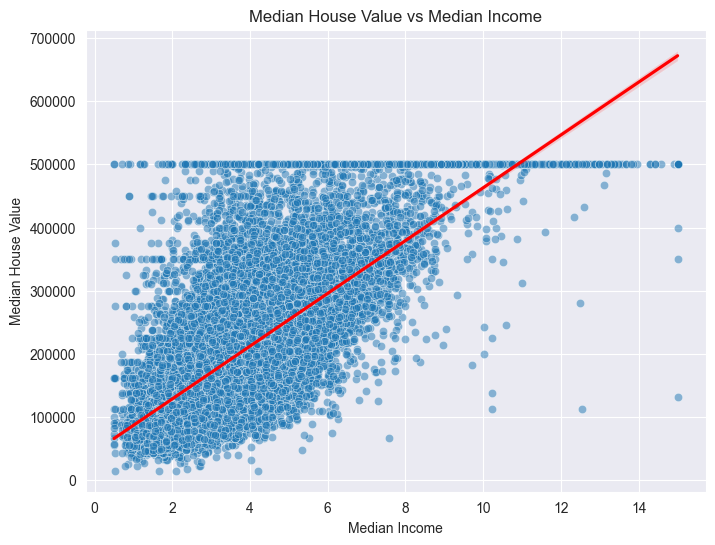

In [182]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='median_income', y='median_house_value', data=df, alpha=0.5)
sns.regplot(x='median_income', y='median_house_value', data=df, scatter=False, color='red')
plt.title('Median House Value vs Median Income')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.show()

We can see the positive correlation, if we increase median income, we increase median house value as well.

House values are capped at 500000, probably dataset cap. There are notable outliers.

#### 1.10.2 Statistical test

In [183]:
corr, p_value = pearsonr(df['median_income'], df['median_house_value'])
print(f"Pearson correlation: {corr:.2f}")
print(f"P-value: {p_value:.5f}")

Pearson correlation: 0.69
P-value: 0.00000


We can confirm from **p-value < 0.05** that the relation is statistically significant, therefore the reject **H0**.

In [184]:
stat, p = stats.ks_2samp(df["total_bedrooms"], df["population"])
print(f"KS statistic: {stat}, p-value: {p}")

KS statistic: 0.59515503875969, p-value: 0.0


### 1.11 Evaluation metrics:
- **MSE - Mean Squared Error**, because we are doing Regression task.

## Data preprocessing

### Dataset division

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
 9   is_san_francisco    20640 non-null  int64  
 10  is_los_angeles      20640 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 1.7 MB


In [186]:
# 70 - 15 - 15 split
x = df.drop("median_house_value", axis=1)
y = df[["median_house_value"]]
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.3, random_state=r_seed
)
x_test, x_val, y_test, y_val = sklearn.model_selection.train_test_split(
    x_test, y_test, test_size=0.5, random_state=r_seed
)
x_train.shape, x_test.shape, x_test.shape, y_train.shape, y_test.shape, y_val.shape

((14448, 10), (3096, 10), (3096, 10), (14448, 1), (3096, 1), (3096, 1))

### Normalization

In [187]:
def show_transformations(dfs: List[any], columns: int = 3, bins: int = 50):
    n = len(dfs)
    rows = (n + columns - 1) // columns

    fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows))
    axes = axes.flatten()
    for i, df in enumerate(dfs):
        axes[i].hist(df[0], bins=bins, color='skyblue', edgecolor='black')
        axes[i].set_title(df[1])
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

In [188]:
def test_transformations(data, dfs: List[any] = [], columns: int = 3, bins: int = 50):
    standart = preprocessing.StandardScaler().fit_transform(data)
    power_box = preprocessing.PowerTransformer(method='box-cox').fit_transform(data)
    show_transformations([(data, "default"), (np.log1p(data), "log1p"), (np.sqrt(data), "sqrt"),
                      (standart, "standart"), (power_box, "power box-cox"), *dfs], columns, bins)

#### total_rooms

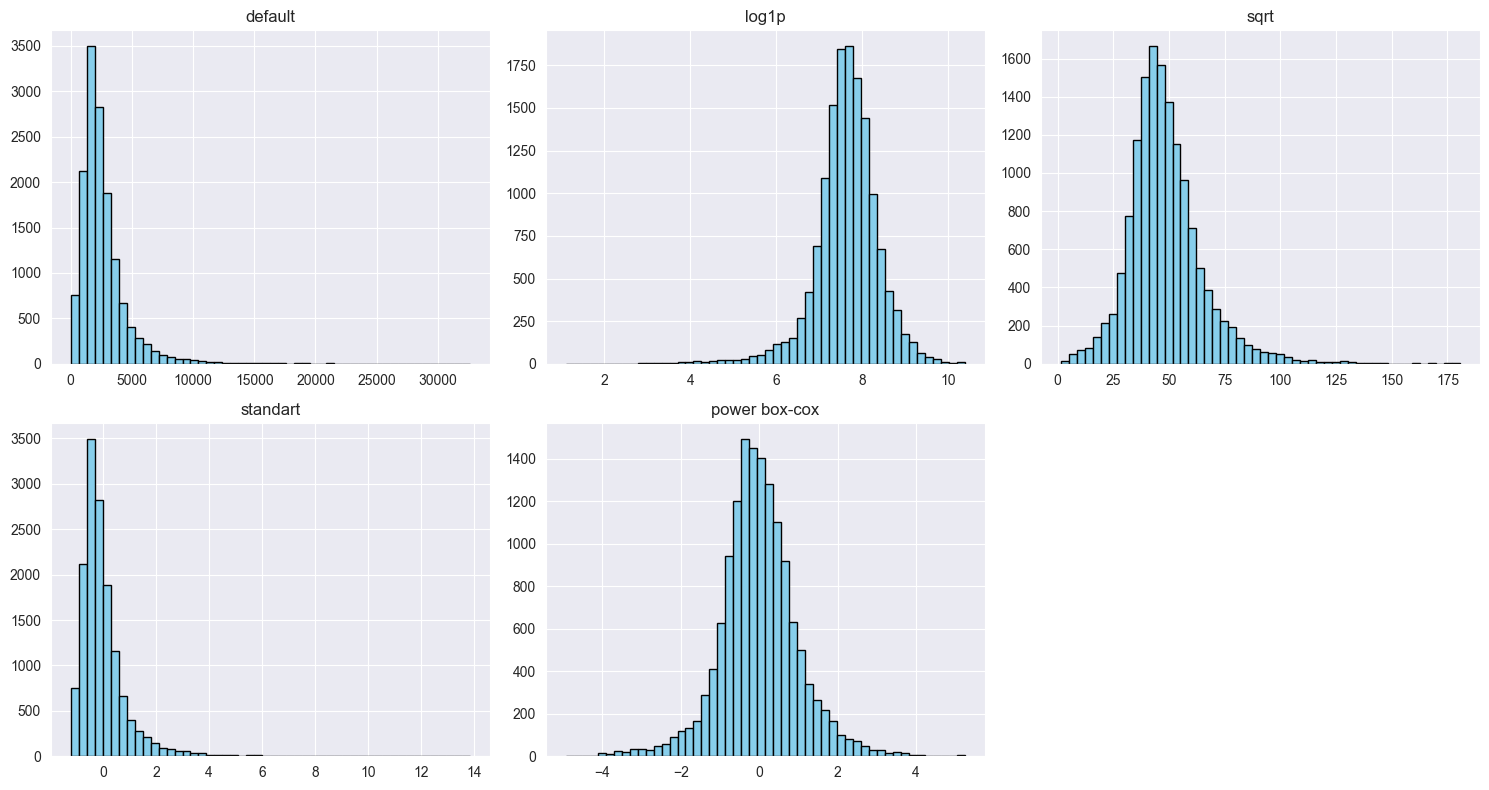

In [189]:
test_transformations(x_train[["total_rooms"]])

log transformation skewed data to the left, so it is to much

sqrt transformation made the data less right skewed but it is not symetrical

standard scaler haven't dont much that is expected considering that this transformer expects roughly normal distribution

power transformer made the data look roughly symetrical

#### median_income

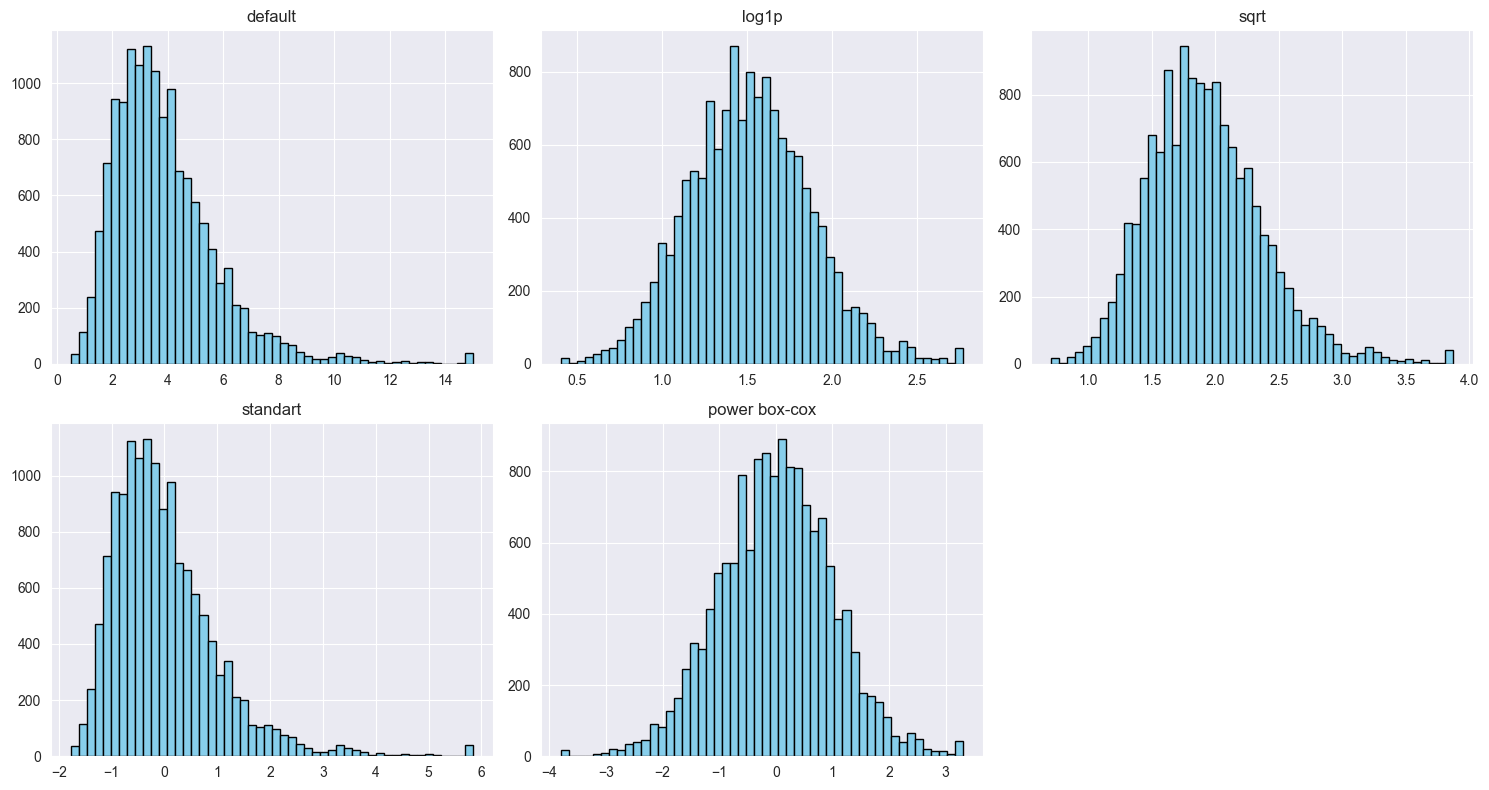

In [190]:
param = "median_income"
test_transformations(x_train[[param]])

Both log and power transformation appear symmetric

#### housing_median_age

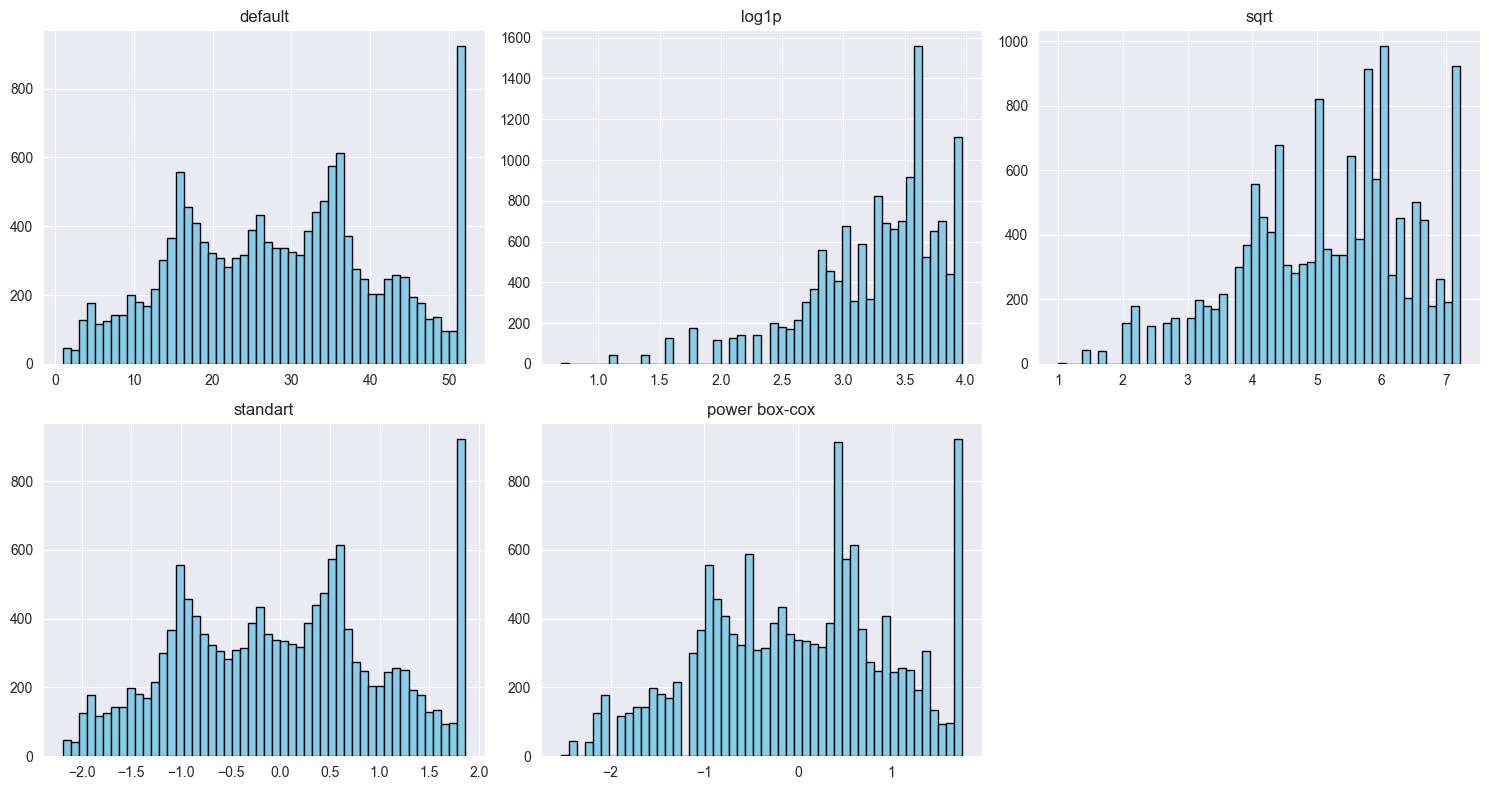

In [191]:
param = "housing_median_age"
test_transformations(x_train[[param]])

None of the transformations above were able to make the data more normal or symmetric, so the Min-Max scaler can be used to preserve the original metric units

#### population

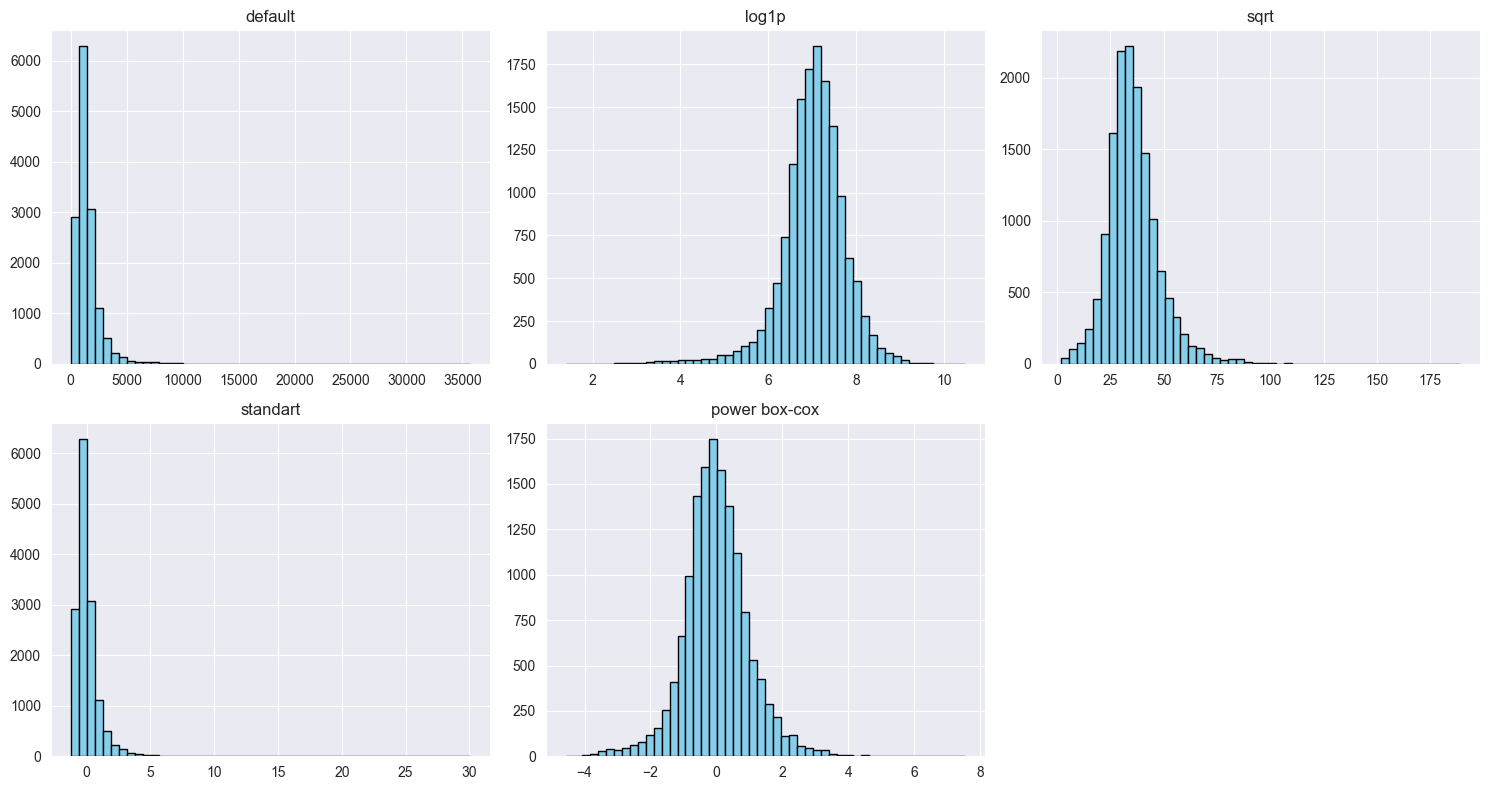

In [192]:
param = "population"
test_transformations(x_train[[param]])

#### households

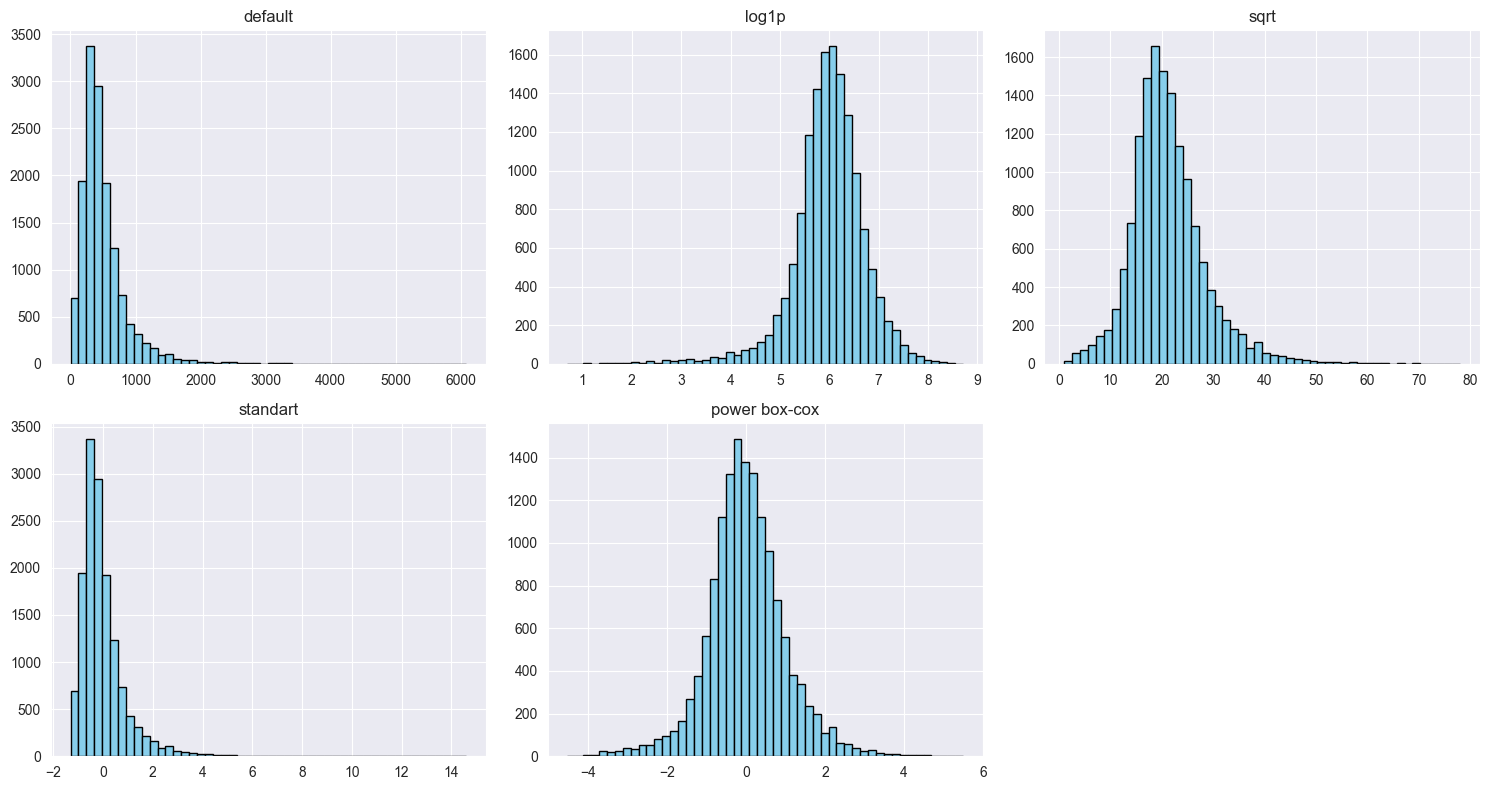

In [193]:
param = "households"
test_transformations(x_train[[param]])

Households appear the least skewed after the power transformation

#### total_bedrooms

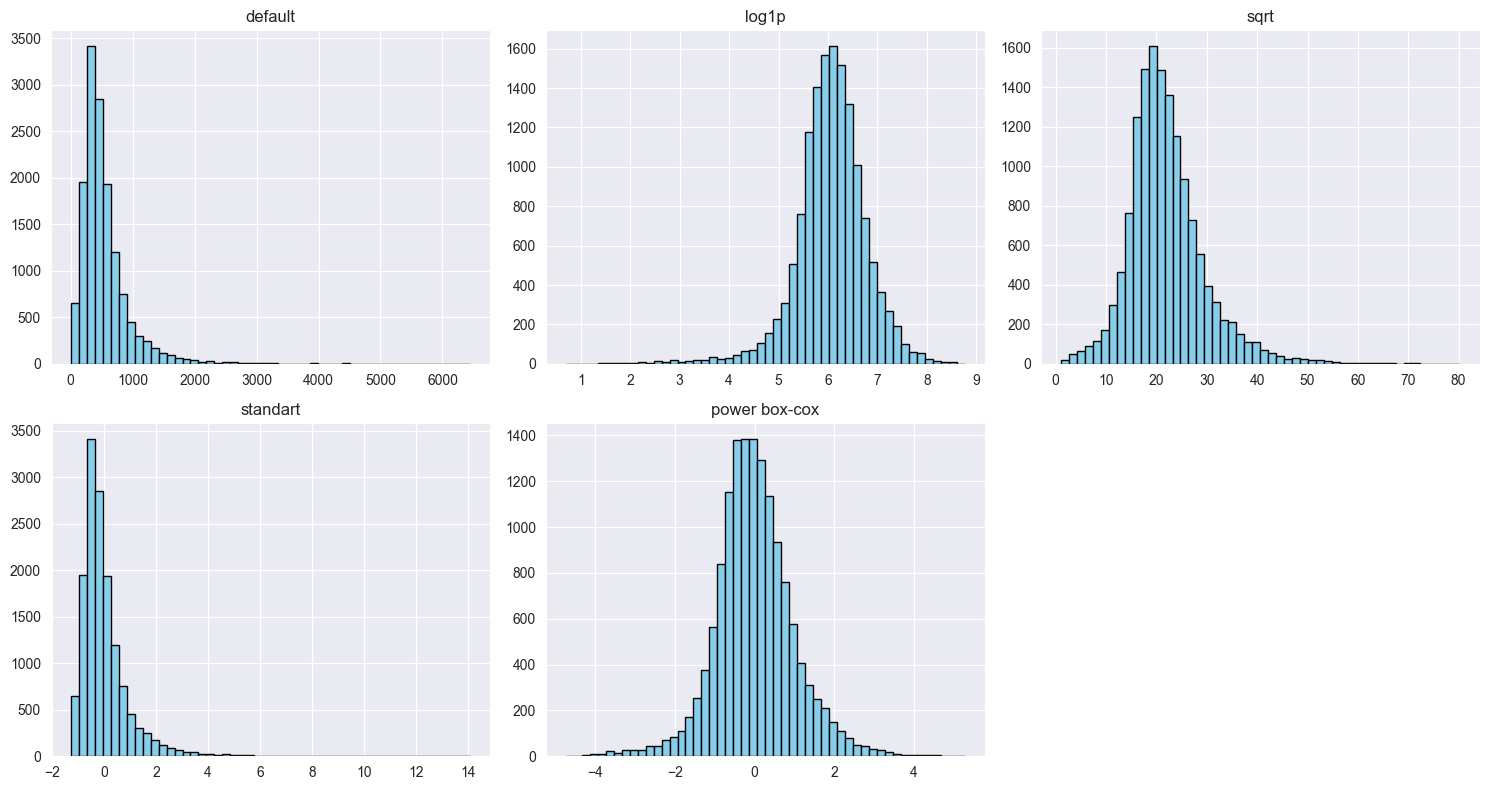

In [194]:
param = "total_bedrooms"
test_transformations(x_train[[param]])

#### latitude & longtitude
Since it is a location metric and its original units are importent MinMax transformer will be used

#### is_san_francisco & is_los_angeles
These are boolean features so there is no need to normalize or rescale them

#### median_house_value

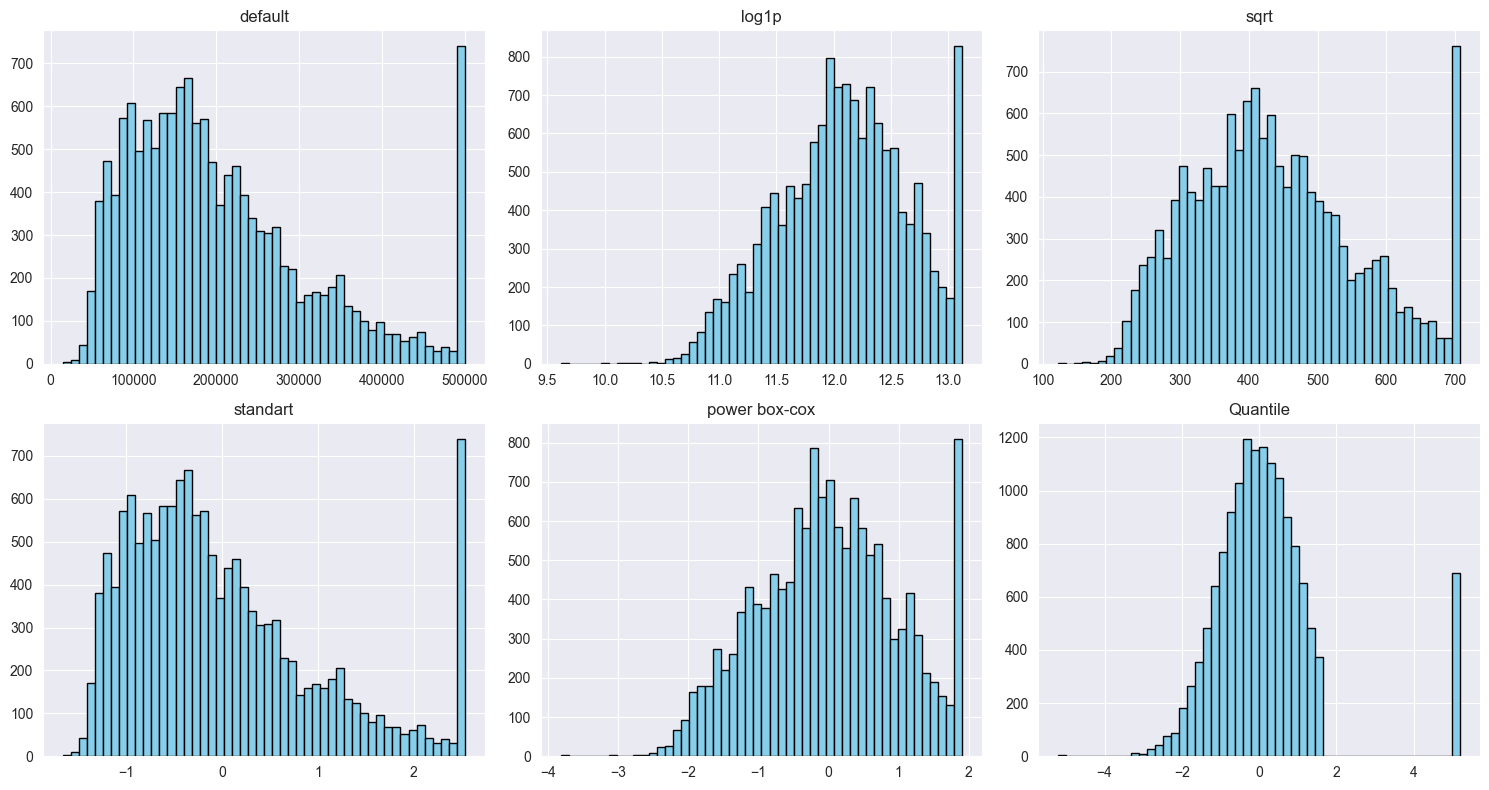

In [195]:
quantile = preprocessing.QuantileTransformer(output_distribution='normal', random_state=r_seed) \
    .fit_transform(y_train)
test_transformations(y_train, [(quantile, "Quantile")])

Sqrt transformation was applied to the predicted variable. Because it spans a large range of values a MinMax scaler should then be used to further normalize it

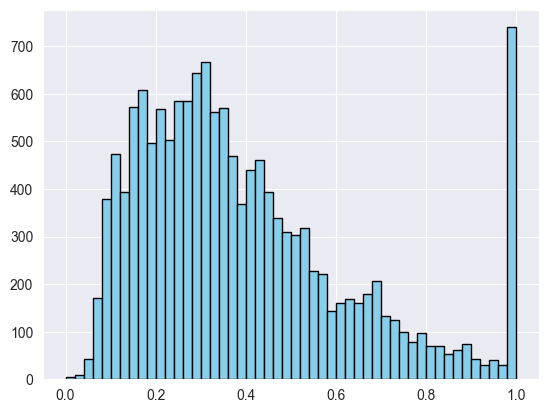

In [196]:
house_value_transformer = Pipeline([
    # ('sqrt', preprocessing.FunctionTransformer(np.sqrt, validate=True)),
    ('scaler', preprocessing.MinMaxScaler())
])

y_train_s = house_value_transformer.fit_transform(y_train)
_ = plt.hist(y_train_s, bins=50, color='skyblue', edgecolor='black')

### Feature selection

In [197]:
x_train.var()

median_income         3.628676e+00
housing_median_age    1.591038e+02
total_rooms           4.678804e+06
total_bedrooms        1.762209e+05
population            1.300113e+06
households            1.460931e+05
latitude              4.561395e+00
longitude             4.011729e+00
is_san_francisco      1.548901e-01
is_los_angeles        2.354123e-01
dtype: float64

All features have sufficiently high variance

In [198]:
selector = SelectKBest(f_regression, k='all')
selector.fit_transform(x_train, y_train)
scores = selector.scores_

ranking = (
    pd.DataFrame({
        "Feature": x_train.columns,
        "F_score": scores,
    })
    .sort_values(by="F_score", ascending=False)
    .reset_index(drop=True)
)

print(ranking)

              Feature       F_score
0       median_income  13000.094763
1    is_san_francisco   1469.736783
2      is_los_angeles   1049.902026
3            latitude    295.272032
4         total_rooms    273.956091
5  housing_median_age    165.884984
6          households     63.002647
7      total_bedrooms     37.099764
8           longitude     35.263954
9          population      8.546627


C:\Users\matze\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


As was noted before features "total_rooms", "total_bedrooms", "population" and "households" have significant correlation, since population has the weakest correlation with predicted variable we can discard it. Also "total_bedrooms" is going to be removed, since it is less correlated with predicted variable then "total_rooms"

In [199]:
def save_transformed(transformer, col_order: List[str], x_train, x_test, x_eval, y_train, y_test, y_eval, path: str):
    assert col_order[-1] == "house_value"
    data = x_train.copy()
    data["house_value"] = y_train
    preprocessor.fit(data)
    X_train = preprocessor.transform(data)
    X_train = pd.DataFrame(
        X_train,
        columns=col_order
    )

    data = x_test.copy()
    data["house_value"] = y_test
    X_test = preprocessor.transform(data)
    X_test = pd.DataFrame(
        X_test,
        columns=col_order
    )

    data = x_val.copy()
    data["house_value"] = y_val
    X_val = preprocessor.transform(data)
    X_val = pd.DataFrame(
        X_val,
        columns=col_order
    )

    os.makedirs(path, exist_ok=True)
    X_train.to_csv(f"{path}/train.csv", index=False)
    X_test.to_csv(f"{path}/test.csv", index=False)
    X_val.to_csv(f"{path}/eval.csv", index=False)
    
    fitted_house_value_transformer = transformer.named_transformers_["predicted"]
    joblib.dump(fitted_house_value_transformer, f"{path}/house_value_scaler.pkl")
    return X_train, X_test, X_val

In [200]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", preprocessing.PowerTransformer(method='box-cox'), ["median_income", "total_rooms", 
            "households", "total_bedrooms", "population"]),
        ("loc", preprocessing.MinMaxScaler(), ["latitude", "longitude", "housing_median_age"]),
        ("bool", preprocessing.FunctionTransformer(), ["is_san_francisco", "is_los_angeles"]),
        ("predicted", house_value_transformer, ["house_value"])
    ]
)
col_order = (
    ["median_income", "total_rooms", "households", "total_bedrooms", "population"] +
    ["latitude", "longitude", "housing_median_age"] +
    ["is_san_francisco", "is_los_angeles"] +
    ["house_value"]
)
path = f"{TRANSFORMED_PATH}/full_features"
X_train, _, _ = save_transformed(preprocessor, col_order, x_train, x_test, x_val, y_train, y_test, y_val, path)

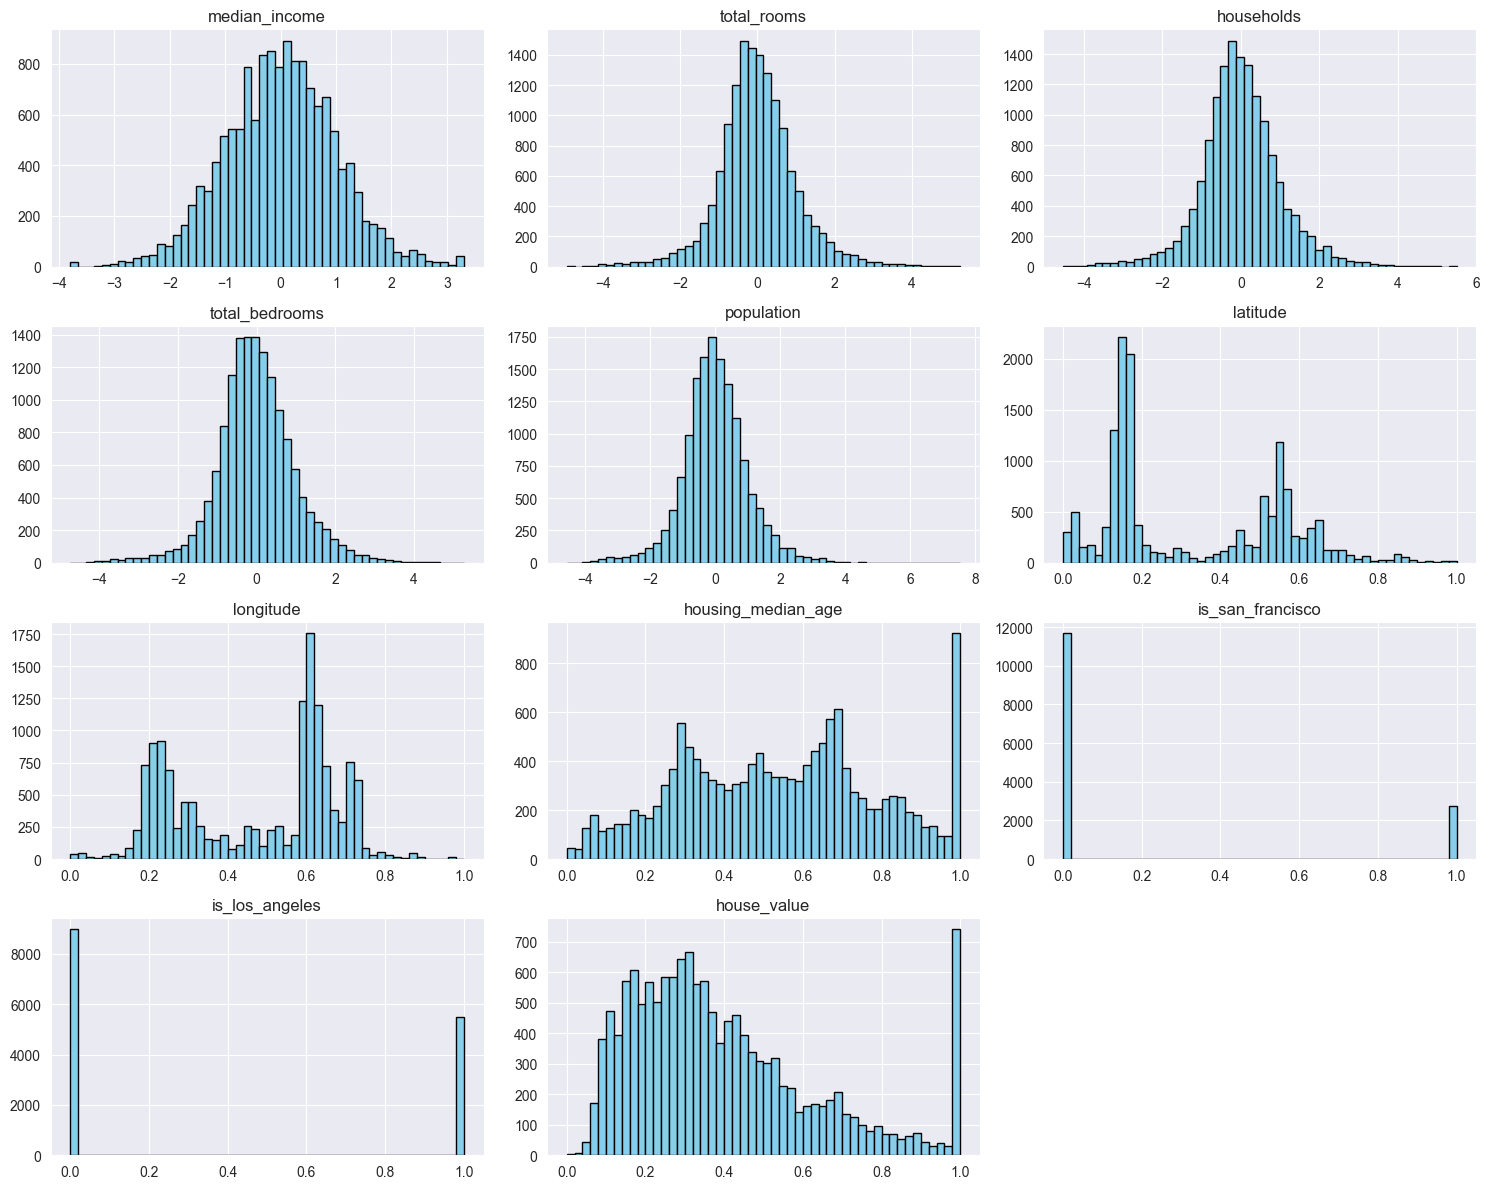

In [201]:
X_train.hist(bins=50, figsize=(15, 12), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

In [204]:
preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        ("num", preprocessing.PowerTransformer(method='box-cox'), ["median_income", "total_rooms"]),
        ("loc", preprocessing.MinMaxScaler(), ["housing_median_age"]),
        ("bool", preprocessing.FunctionTransformer(), ["is_san_francisco", "is_los_angeles"]),
        ("predicted", house_value_transformer, ["house_value"])
    ]
)
col_order = (
    ["median_income", "total_rooms"] +
    ["housing_median_age"] +
    ["is_san_francisco", "is_los_angeles"] +
    ["house_value"]
)
path = f"{TRANSFORMED_PATH}/small"
X_train, _, _ = save_transformed(preprocessor, col_order, x_train, x_test, x_val, y_train, y_test, y_val, path)

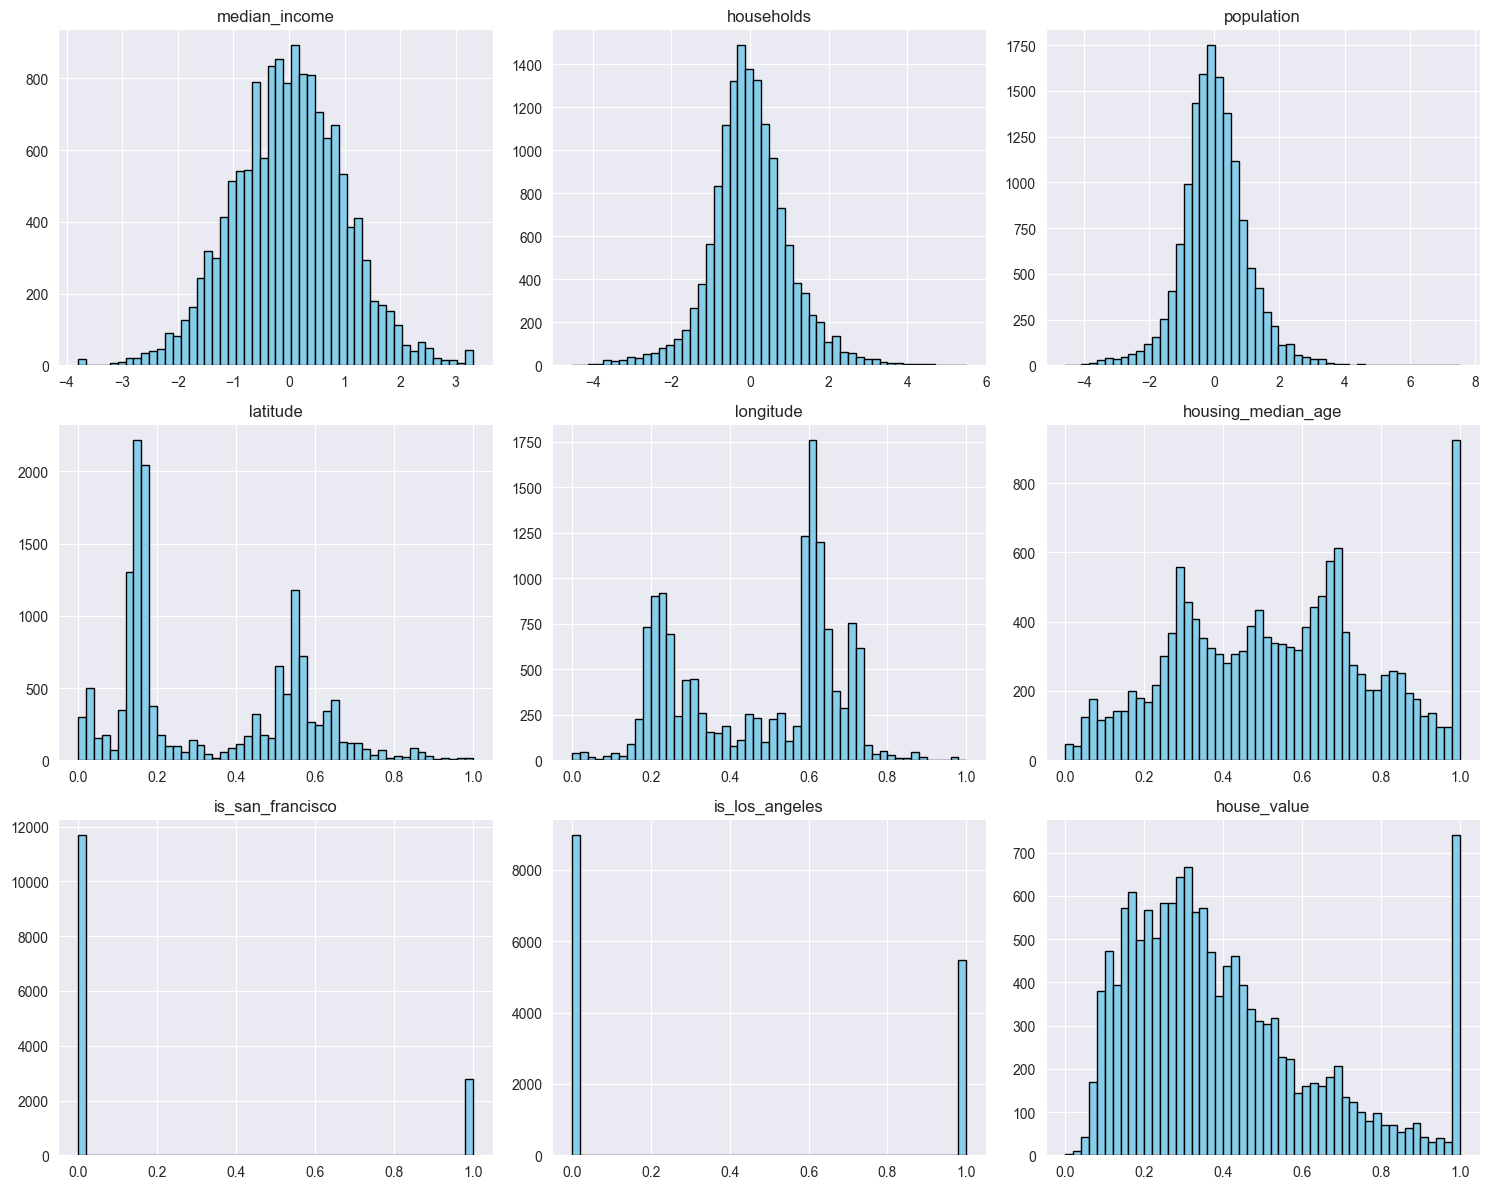

In [203]:
X_train.hist(bins=50, figsize=(15, 12), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()